<a href="https://colab.research.google.com/github/Enan456/erdos-fall-2022/blob/main/LSTM_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

This step takes in a '|' delimited file containing the congressional record for the 99th US Congress session. 

The file is read in and the text is split into a list of sentences. The sentences are then split into words. The words are then converted to lowercase and punctuation is removed. The words are then converted to integers using a token map. The dictionary is created by taking the most common words in the corpus. The sentences are then padded to be the same length. 

In [ ]:
import os

In [ ]:
df = pd.read_csv('/content/congressional-speeches_raw_metadata_combined_daily_110.csv',delimiter='|')

In [ ]:
df

,speech_id,speech,speakerid,lastname,firstname,chamber,state,gender,party,district,nonvoting
0,1100000001,The Chair lays before the Senate the certifica...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1100000002,If the Senators to be sworn will now present t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1100000003,Congratulations.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1100000004,The clerk will read the names of the next group.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1100000005,respectively. advanced to the desk of the Vice...,110114511.0,SPECTER,ARLEN,S,PA,M,D,NaN,voting
...,...,...,...,...,...,...,...,...,...,...,...
114096,1100114097,Without objection. it is so ordered. The Senat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114097,1100114098,Mr President. section 307 of S. Con. Res. 21. ...,110116431.0,CONRAD,KENT,S,ND,M,D,NaN,voting
114098,1100114099,Mr. President. I rise today -with a heavy hear...,110113931.0,BAYH,EVAN,S,IN,M,D,NaN,voting
114099,1100114100,Mr. President. as I travel and talk to folks a...,110113531.0,COLEMAN,NORM,S,MN,M,R,NaN,voting


In [1]:
import pandas as pd
def read_data(filename):
    print('Reading file: ' + filename)
    data = pd.read_csv(filename, sep = '|',  quoting=3, low_memory=False)
    data = data.dropna(subset=['lastname', 'speech'])
    #3drop instances where speech is laess than 500 characters
    data = data[data['speech'].str.len() > 500]
    data = data.reset_index(drop=True)
    data['text'] = data['speech']
    data = data[['text', 'party']]
    return data

#find files that start with congress iin data folder
import os
files = []
for i in range(97,115):
    path = os.getcwd() + '/data/congressional-speeches_raw_metadata_combined_daily_' + str(i) + '.csv'

    #concatenate all files into one dataframe
    files.append(read_data(path))
data = pd.concat(files, ignore_index=True)

Reading file: /content/data/congressional-speeches_raw_metadata_combined_daily_97.csv
Reading file: /content/data/congressional-speeches_raw_metadata_combined_daily_98.csv
Reading file: /content/data/congressional-speeches_raw_metadata_combined_daily_99.csv
Reading file: /content/data/congressional-speeches_raw_metadata_combined_daily_100.csv
Reading file: /content/data/congressional-speeches_raw_metadata_combined_daily_101.csv
Reading file: /content/data/congressional-speeches_raw_metadata_combined_daily_102.csv
Reading file: /content/data/congressional-speeches_raw_metadata_combined_daily_103.csv
Reading file: /content/data/congressional-speeches_raw_metadata_combined_daily_104.csv
Reading file: /content/data/congressional-speeches_raw_metadata_combined_daily_105.csv
Reading file: /content/data/congressional-speeches_raw_metadata_combined_daily_106.csv
Reading file: /content/data/congressional-speeches_raw_metadata_combined_daily_107.csv
Reading file: /content/data/congressional-spee

In [2]:
!nividia-smi

/bin/bash: nividia-smi: command not found


In [3]:
import pandas as pd
import re
from typing import List
from sklearn.model_selection import train_test_split
train, val = train_test_split(data, test_size=0.3, stratify=data['party'], random_state=42)
val,test = train_test_split(data, test_size=0.1667, stratify=data['party'], random_state=42)

def tokenize(text:str)->List[str]:
    #clean text to remove punctuation
    try:
        text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)
        text = re.sub(r'[^\w\s]','',text)
        text = re.sub(r'\"','',text)
    except:
        print(text)
    #split text into words and lowercase
    words = text.lower().split()
    return words

train['tokens'] = train['text'].apply(tokenize)
val['tokens'] = val['text'].apply(tokenize)
test['tokens'] = test['text'].apply(tokenize)
#get max length of speech
max_len = max(train['tokens'].apply(len))
print("tokenized")
train.to_csv('data/train.csv', index=False)
val.to_csv('data/val.csv', index=False) 
test.to_csv('data/test.csv', index=False) 

tokenized


In [5]:
#create a token map
from collections import OrderedDict, Counter
import json
token_map = OrderedDict()
token_map['<PAD>'] = 0
token_map['<UNK>'] = 1

#use tokens column to create a token map
token_list = [i for j in train['tokens'] for i in j]
#sort byh frequency
token_freq = Counter(token_list)
token_freq = sorted(token_freq.items(), key=lambda x: x[1], reverse=True)
#add to token map
for token, freq in token_freq:
    token_map[token] = freq

full_token_map = {
    'token_to_index': OrderedDict(),
    'index_to_token': OrderedDict(),
    'index_to_value': OrderedDict()
}

for i, (token, freq) in enumerate(token_map.items()):
    #removes words that appear less than 2 times ( takes care of misspellings and garbage words)
    if freq > 1:
        full_token_map['token_to_index'][token] = i
        full_token_map['index_to_token'][i] = token
        full_token_map['index_to_value'][i] = freq

#save token map

with open('token_map.json', 'w') as f:
    json.dump(full_token_map, f)

In [1]:
source_folder = 'data'
destination_folder = 'model/'


# Libraries

In [2]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torch.utils.data import DataLoader
# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(device)


cuda


In [ ]:
max_len

22683

In [4]:
from torch.utils.data import Dataset
import numpy as np
import json
import pandas as pd
max_len = 2000
class TextDataset(Dataset):
        
        def __init__(self, df, max_len, token_map):
            self.df = df
            self.text = df['tokens'].values
            self.targets = df['party'].values
            self.max_len = max_len
            self.token_map = token_map

        def tokenize(self, text):
            tokenized = np.array([self.token_map['token_to_index'].get(token, 1) for token in text] + [0] * (self.max_len - len(text)))
            if len(tokenized) > self.max_len:
                tokenized = tokenized[:self.max_len]
            return tokenized

        def __len__(self):
            return len(self.df)

        def __getitem__(self, index):
            text = self.text[index]
            target = self.targets[index]
            if target == 'D':
                target = 0
            else:
                target = 1

            return {
                'text': torch.from_numpy(tokens := self.tokenize(text)).to(torch.device("cuda")),
                'target': torch.tensor([target], dtype=torch.float32, device="cuda"),
                'length': torch.tensor([len(tokens)],dtype=torch.float32 ,device = "cuda")
            }

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/val.csv')
with open('token_map.json', 'r') as f:
    token_map = json.load(f)
tds_train = TextDataset(df_train, max_len=max_len, token_map=token_map)
tds_test = TextDataset(df_test, max_len=max_len, token_map=token_map)

def collate_fn(batch):
    texts, labels, lengths = [], [], []
    for label, txt, length in batch:
        texts.append(txt)
        labels.append(label)
        lengths.append(length)
    return texts, labels, lengths

dl_train = DataLoader(tds_train, batch_size=512, shuffle=False)
dl_test = DataLoader(tds_test, batch_size=512, shuffle=False)

In [ ]:
dl_train = DataLoader(tds_train, batch_size=256, shuffle=False)
dl_test = DataLoader(tds_test, batch_size=256, shuffle=False)

# Preliminaries

# Models

In [5]:
class LSTM(nn.Module):

    def __init__(self, dimension=128, num_classes=1):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(token_map["index_to_token"]), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(dimension, num_classes)

    def forward(self, text, text_len: torch.Tensor):

        text_emb = self.embedding(text)
        
        output, (hidden, cell) = self.lstm(text_emb)

        output = hidden[-1, :, :]

        # Pass the output through the fully connected layer
        output = self.fc(output)

        # Apply the sigmoid activation function
        output = torch.sigmoid(output)

        return output


# Training

In [6]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [7]:
# Training Function
import time
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = dl_train,
          valid_loader = dl_test,
          num_epochs = 5,
          eval_every = len(dl_test) // 3,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    start_time = time.time()
    batch_times = []
    # training loop
    model.train()
    
    for epoch in range(num_epochs):
        for batch in train_loader:
            label = batch['target'].to(device)
            text = batch['text'].to(device)
            length = batch['length'].to(device)
            output = model(batch['text'], batch['length']).cuda()
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    
                    # validation loop
                    for batch in valid_loader:
                        label = batch['target'].to(device)
                        text = batch['text'].to(device)
                        length = batch['length'].to(device)
                        output = model(batch['text'], batch['length'])
                        loss = criterion(output, label)
                        
                        valid_running_loss += loss.item()
                
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                print("time: ", (time.time() - start_time)/60)
                batch_times.append(time.time() - start_time)
                print("time remaining: ", (num_epochs*len(train_loader) - global_step) * np.mean(batch_times)/60)
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + 'model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    # todo ensure shapes are right accross, max size and length need to be looked at

In [8]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.007)
train(model=model, optimizer=optimizer, num_epochs=5)

Epoch [1/5], Step [424/5345], Train Loss: 0.6939, Valid Loss: 0.6917
time:  17.92533492644628
time remaining:  88210.57514802615
Model saved to ==> model/model.pt
Model saved to ==> model/metrics.pt
Epoch [1/5], Step [848/5345], Train Loss: 0.6918, Valid Loss: 0.6924
time:  36.01489131450653
time remaining:  121284.60142787694
Epoch [2/5], Step [1272/5345], Train Loss: 0.6920, Valid Loss: 0.6916
time:  54.260831439495085
time remaining:  146901.0039675474
Model saved to ==> model/model.pt
Model saved to ==> model/metrics.pt
Epoch [2/5], Step [1696/5345], Train Loss: 0.6919, Valid Loss: 0.6918
time:  72.46636253595352
time remaining:  164813.87776337366
Epoch [2/5], Step [2120/5345], Train Loss: 0.6919, Valid Loss: 0.6917
time:  90.34400988817215
time remaining:  174802.38943064213
Epoch [3/5], Step [2544/5345], Train Loss: 0.6921, Valid Loss: 0.6919
time:  107.96381117502848
time remaining:  176918.2981397205
Epoch [3/5], Step [2968/5345], Train Loss: 0.6918, Valid Loss: 0.6919
time:  

Model loaded from <== model//metrics.pt


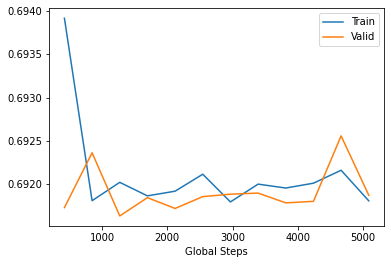

In [9]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.legend()
plt.show() 

In [10]:
from google.colab import files

files.download('model/model.pt')
files.download('model/metrics.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation

In [19]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.6293435096740723):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            label = batch['target'].to(device)
            text = batch['text'].to(device)
            length = batch['length'].to(device)
            output = model(batch['text'], batch['length'])
            y_pred.extend(torch.sigmoid(output).cpu().numpy())
            y_true.extend(label.cpu().numpy())
    print('Classification Report:')
    y_pred = np.array(y_pred) >= threshold
    y_true = np.array(y_true)
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

In [11]:
import pandas as pd
df_test = pd.read_csv('data/val.csv')
tds_test = TextDataset(df_test, max_len=max_len, token_map=token_map)

def collate_fn(batch):
    texts, labels, lengths = [], [], []
    for label, txt, length in batch:
        texts.append(txt)
        labels.append(label)
        lengths.append(length)
    return texts, labels, lengths

dl_test = DataLoader(tds_test, batch_size=512, shuffle=False)

Model loaded from <== model//model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8934    0.0014    0.0029    309404
           0     0.5253    0.9998    0.6888    342001

    accuracy                         0.5256    651405
   macro avg     0.7094    0.5006    0.3458    651405
weighted avg     0.7001    0.5256    0.3630    651405



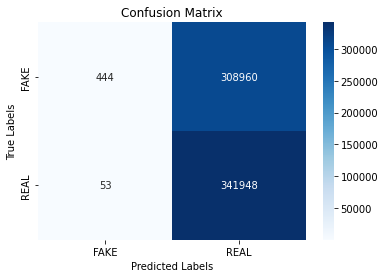

In [20]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)
test = ["I am committed to ensuring the safety and security of our great nation. That is why I am a strong proponent of a robust defense budget and a strong military. We live in a dangerous world, and we must be prepared to defend ourselves against those who would do us harm. Whether it is terrorists, rogue nations, or other threats, we must be ready to protect our country and our people That is why I support increasing funding for our military and investing in the latest technology and equipment. We must also continue to support our brave men and women in uniform, ensuring they have the training and support they need to do their jobs effectively. Furthermore, I believe in a strong national defense not just for our own protection, but for the protection of our allies and partners around the world. We must work together with other nations to confront global challenges and maintain peace and stability.","I am committed to ensuring that every American has access to quality, affordable healthcare. Healthcare is a right, not a privilege, and it is time for our country to catch up with the rest of the developed world in this regard. We must work to expand Medicaid and other programs that provide healthcare to those who cannot afford it. We must also work to make healthcare more affordable for everyone, by lowering the cost of prescription drugs and increasing competition in the healthcare industry. Furthermore, we must protect and strengthen the Affordable Care Act, also known as Obamacare. This law has provided millions of Americans with access to healthcare, and we must not let the current administration and Republican Congress take it away. In addition, we must also focus on preventative care and public health. By investing in programs that promote healthy lifestyles and prevent diseases, we can save lives and reduce healthcare costs in the long run."]
load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
#predict 
evaluate(best_model, dl_test)